**Assignment 3:**

In [1]:
!pip install --upgrade shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 4.0 MB/s eta 0:00:00


In [2]:
!pip install h2o
!pip install xgboost
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

# for outlier preprocessing
!pip install datasist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.6/265.6 MB 4.6 MB/s eta 0:00:00
Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.4 MB/s eta 0:00:00


In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import h2o
from h2o.automl import H2OAutoML

In [4]:
data = pd.read_csv("Housing.csv")

In [5]:
numeric_cols=[]
cat_cols=[]
for column in data.columns:
    if pd.api.types.is_numeric_dtype(data[column]):
        print(f"The column '{column}' is numeric.")
        numeric_cols.append(column)
    else:
        print(f"The column '{column}' is not numeric.")
        cat_cols.append(column)

The column 'price' is numeric.
The column 'area' is numeric.
The column 'bedrooms' is numeric.
The column 'bathrooms' is numeric.
The column 'stories' is numeric.
The column 'mainroad' is not numeric.
The column 'guestroom' is not numeric.
The column 'basement' is not numeric.
The column 'hotwaterheating' is not numeric.
The column 'airconditioning' is not numeric.
The column 'parking' is numeric.
The column 'prefarea' is not numeric.
The column 'furnishingstatus' is not numeric.


In [6]:
#separate numeric and categorical columns
print(numeric_cols)
print(cat_cols)

['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']
['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']


In [7]:
#encode the categorical values using label encoding
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

In [8]:
for col in cat_cols:
    data[col]=le.fit_transform(data[col])
data

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,1,0,1,0,0,2,0,2
541,1767150,2400,3,1,1,0,0,0,0,0,0,0,1
542,1750000,3620,2,1,1,1,0,0,0,0,0,0,2
543,1750000,2910,3,1,1,0,0,0,0,0,0,0,0


**Removing outliers**

<Axes: >

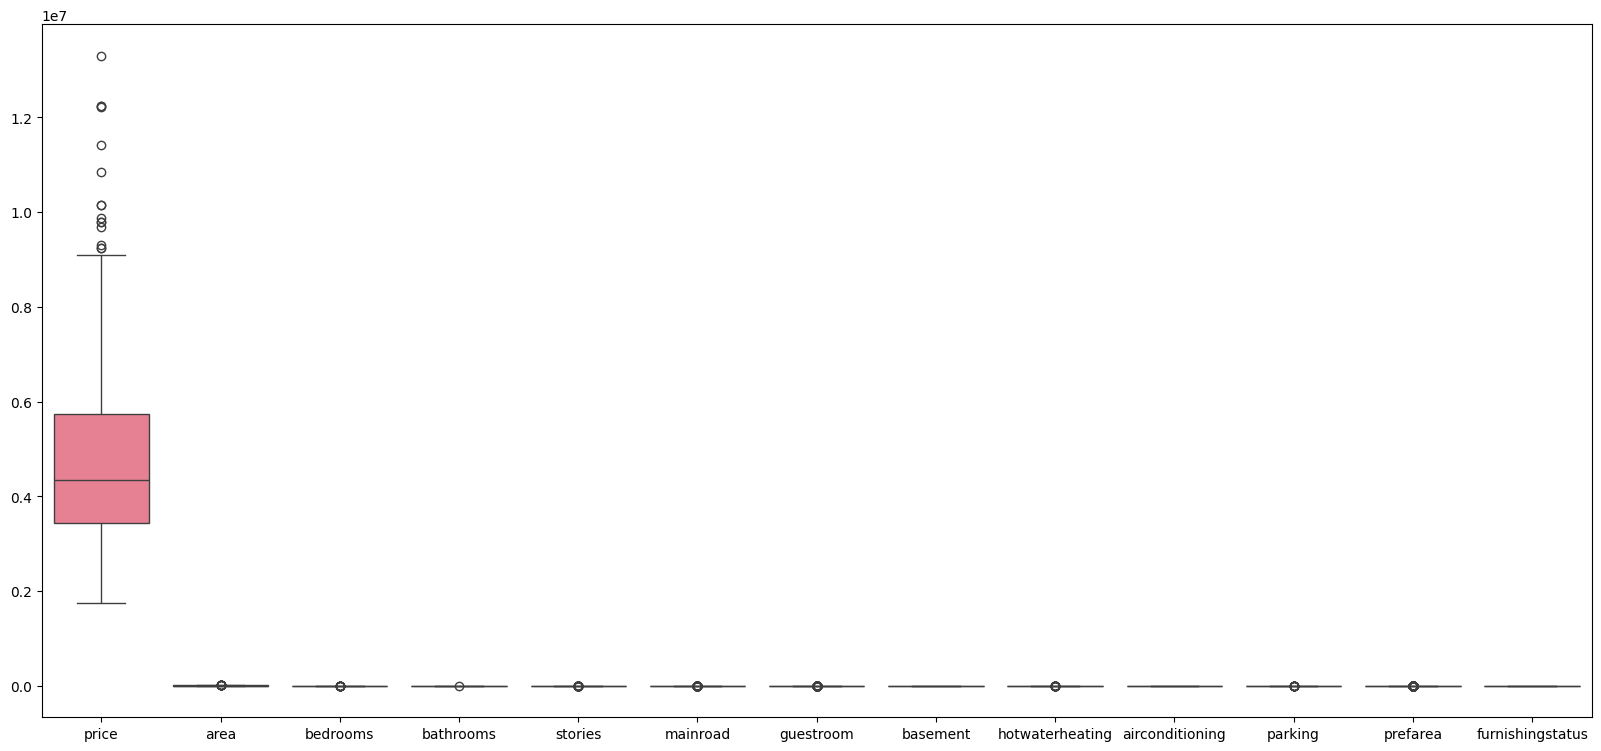

In [9]:
# Checking the Ranges of the predictor variables and dependent variable
plt.figure(figsize=(20, 9))
sns.boxplot(data=data)

In [10]:
from datasist.structdata import detect_outliers

index = detect_outliers(
    data,
    0,
    [
        "area",
        "bedrooms",
        "bathrooms",
        "stories",
        "mainroad",
        "guestroom",
        "basement",
        "hotwaterheating",
        "airconditioning",
        "parking",
        "prefarea",
        "furnishingstatus",
    ],
)
len(index)

308

In [11]:
for col in data[
    [
        "area",
        "bedrooms",
        "bathrooms",
        "stories",
        "mainroad",
        "guestroom",
        "basement",
        "hotwaterheating",
        "airconditioning",
        "parking",
        "prefarea",
        "furnishingstatus",
    ]
]:
    outliers_indices = detect_outliers(data, 0, [col])
    col_median = data[col].median()
    data[col].iloc[outliers_indices] = col_median

<Axes: >

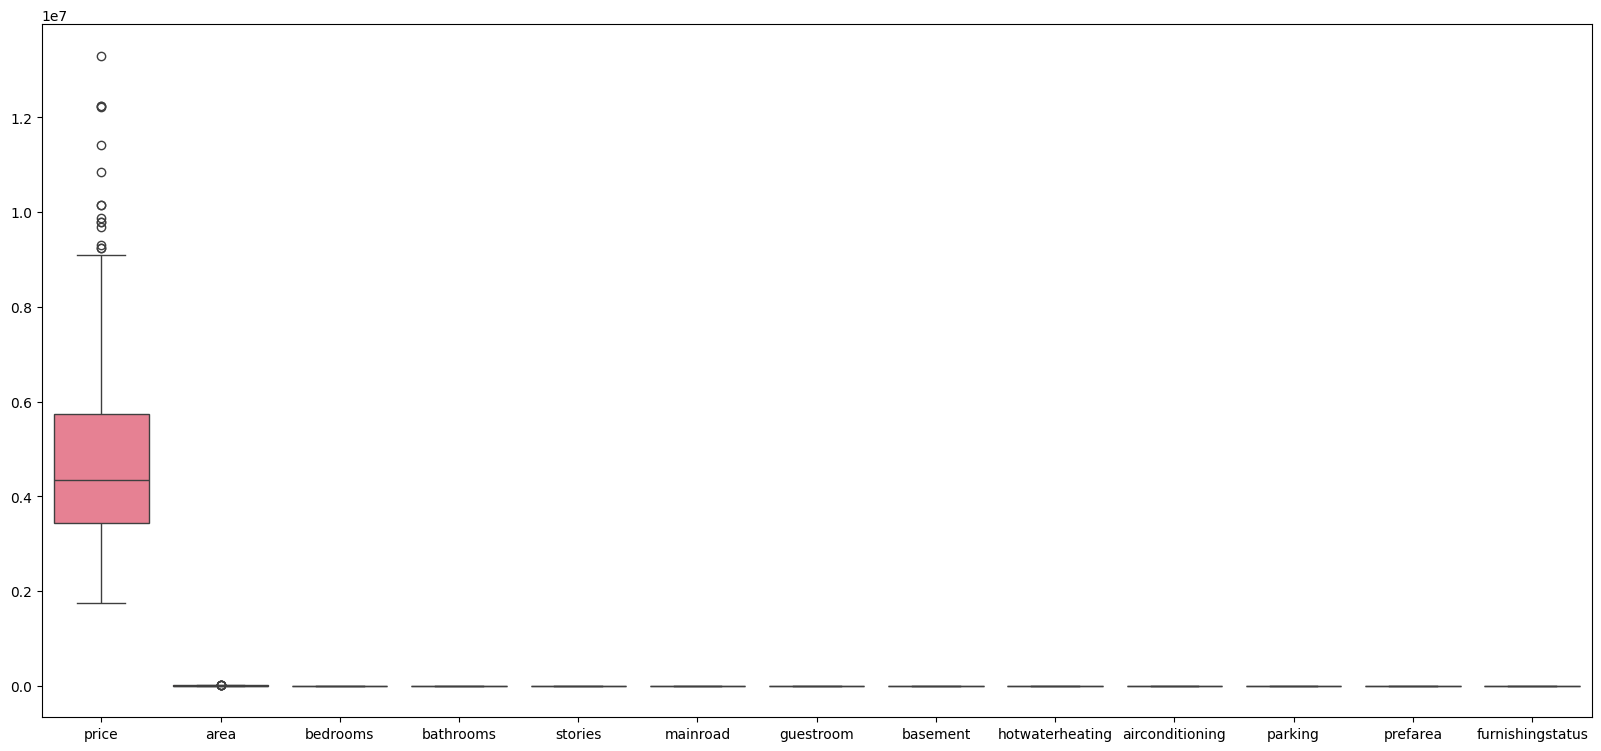

In [12]:
# Checking the Ranges of the predictor variables and dependent variable after removing outliers
plt.figure(figsize=(20, 9))
sns.boxplot(data=data)

In [13]:
# Splitting target and predictor variables.
X = data.drop('price', axis=1)
y = data['price']

In [14]:
print(f"Mean value: {round(y.mean(), 2)}")

Mean value: 4766729.25


In [15]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)

**1. Fit a linear model and interpret the regression coefficients**

**Linear Regression**

In [16]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [19]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# Make predictions using the testing set
y_pred = model.predict(X_test)
# The mean squared error
print('Mean squared error: %.2f'% mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'% r2_score(y_test, y_pred))
r2 = r2_score(y_test,y_pred)
print('R^2 score on test set =',r2)

Mean squared error: 1448719858120.27
Coefficient of determination: -6.16
R^2 score on test set = -6.158136139345809


In [20]:
#Using OLS for finding the p value to check the significant features
import statsmodels.api as sm

model = sm.OLS(y_train, X_train).fit()

# Print out the statistics
model.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     47.87
Date:                Mon, 18 Mar 2024   Prob (F-statistic):           8.15e-54
Time:                        03:35:23   Log-Likelihood:                -6299.4
No. Observations:                 408   AIC:                         1.262e+04
Df Residuals:                     399   BIC:                         1.265e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
area               311.0177     36.548      8.510      0.000     239.167     382.868
bedrooms          1.903e+05   1.16e+05      1.643      0.101   -3.75e+04    4.18e+05
bathrooms         8.937e+05   1.27e+05      7.024      0.000    6.44e+05    1.14e+06
stories           5.655e+05   1.16e+05      4.869      0.000    3.37e+05    7.94e+05
mainroad           3.73e+05   3.79e+05      0.984      0.326   -3.72e+05    1.12e+06
guestroom         1.565e-10   3.26e-11      4.797      0.000    9.23e-11    2.21e-10
basement          4.146e+05    1.3e+05      3.194      0.002    1.59e+05     6.7e+05
hotwaterheating  -1.762e-11   2.44e-11     -0.723      0.470   -6.56e-11    3.03e-11
airconditioning   7.929e+05   1.32e+05      6.023      0.000    5.34e+05    1.05e+06
parking           3.542e+05   7.82e+04      4.527      0.000       2e+05    5.08e+05
prefarea                  0          0        nan        nan           0           0
furnishingstatus -1.525e+05   8.74e+04     -1.746      0.082   -3.24e+05    1.92e+04
==============================================================================
Omnibus:                       71.814   Durbin-Watson:                   0.902
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              154.823
Skew:                           0.923   Prob(JB):                     2.40e-34
Kurtosis:                       5.387   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Among the features, bedrooms, mainroad, guestroom, prefarea, and furnishingstatus have p-values greater than 0.05, suggesting they may not significantly influence the property price, all other features are significant. The coefficient of hotwaterheating and furnishingstatus are negative which means they have a negative relationship with price, and all other coefficient are positive so their relationship with price is positive.

**SHAP**

In [21]:
shap.initjs()

In [22]:
explainer = shap.Explainer(model.predict, X_train)
shap_values = explainer(X_test)

PermutationExplainer explainer: 138it [00:10,  2.14it/s]                         


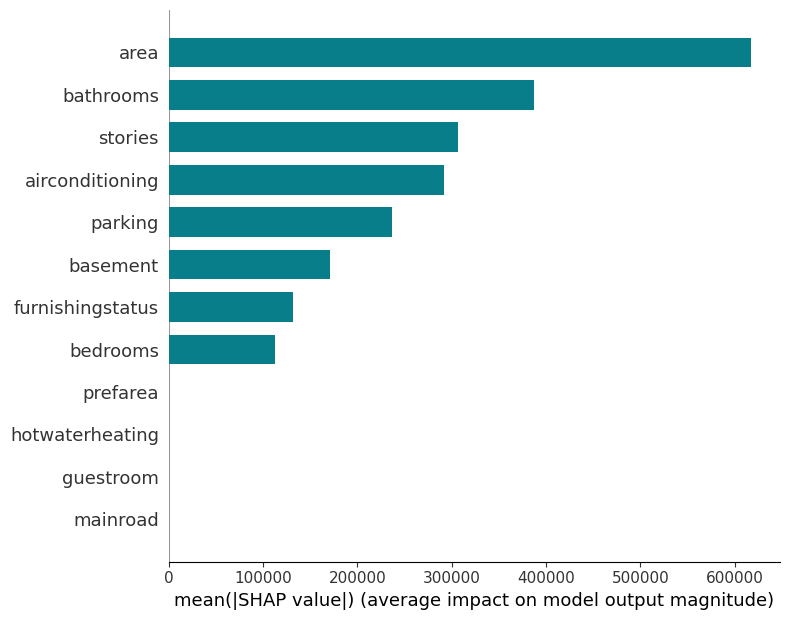

In [23]:
# shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_test, plot_type="bar", color='#087E8B')

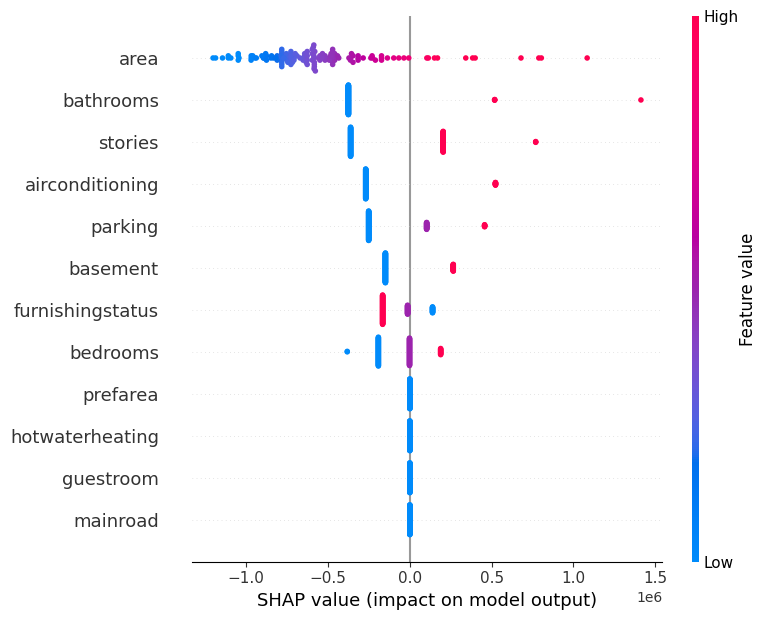

In [24]:
shap.summary_plot(shap_values, X_test)

For the linear regression model from the plots it can be interpreted that Area, Bathrooms, Stories and Airconditioning are the important features for this regressor model. These are the major features in determining the Price of house.

**2. Fit a tree-based model and interpret the nodes**

**Random Forest**

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [27]:
# Make predictions using the testing set
y_pred = model.predict(X_test)
# The mean squared error
print('Mean squared error: %.2f'% mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'% r2_score(y_test, y_pred))
r2 = r2_score(y_test,y_pred)
print('R^2 score on test set =',r2)

Mean squared error: 2609284713102.19
Coefficient of determination: -11.89
R^2 score on test set = -11.892496156526608


**SHAP**

In [29]:
explainer = shap.Explainer(model.predict, X_train)
shap_values = explainer(X_test)

PermutationExplainer explainer:  31%|███▏      | 43/137 [02:26<05:43,  3.65s/it]


KeyboardInterrupt: 

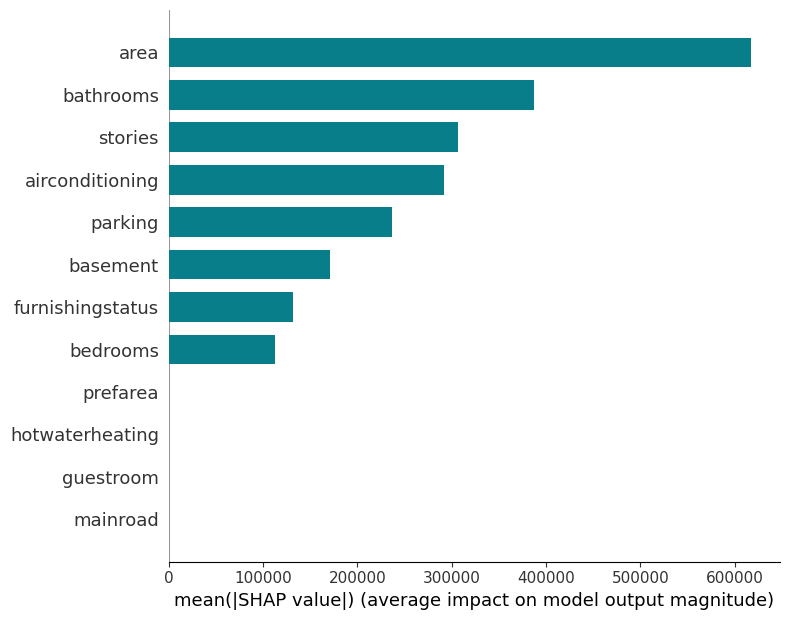

In [30]:
# shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_test, plot_type="bar", color='#087E8B')

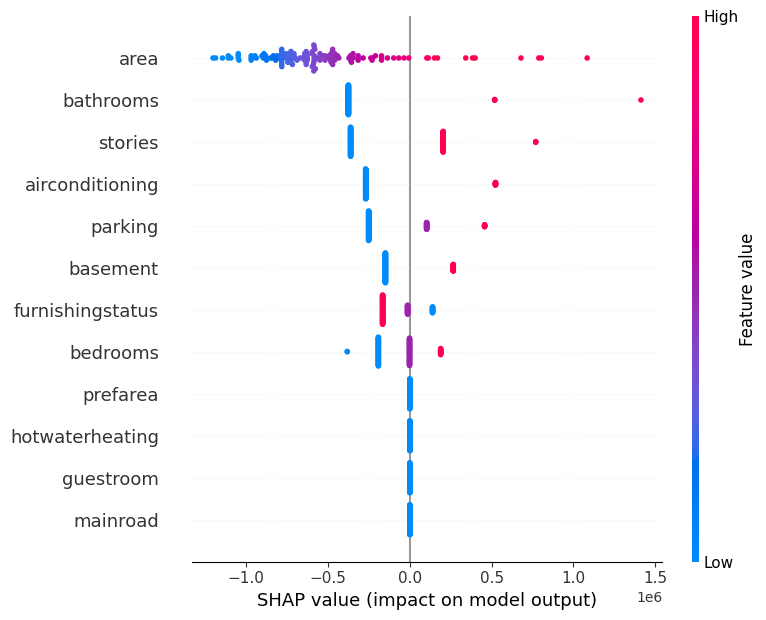

In [31]:
shap.summary_plot(shap_values, X_test)

For the random forest model according to SHAP Analysis the important features to determine the target variable are Area, Bathrooms and Basemet. Area and Bathrooms are the common feature which is important for both Random Forest and Linear Regression Model. Area has the highest value of feature importance and is placed first on the scale.

**3. Use auto ml to find the best model**

**Auto ML**

In [32]:
# Initialize H2O
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.22" 2024-01-16; OpenJDK Runtime Environment (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1); OpenJDK 64-Bit Server VM (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpjhds8790
  JVM stdout: /tmp/tmpjhds8790/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpjhds8790/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,4 days
H2O_cluster_name:,H2O_from_python_unknownUser_fngaq3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [33]:
data = h2o.H2OFrame(data)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
data.head()

In [34]:
train, test = data.split_frame(seed = 1234, destination_frames = ["train.hex", "test.hex"])

In [35]:
# check the number of train set and test set
train["is_train"] = 1
test["is_train"] = 0

drift_data = train.rbind(test)
drift_data["is_train"] = drift_data["is_train"].asfactor()

In [36]:
drift_data["is_train"].table()

is_train,Count
0,130
1,415


In [37]:
x = list(set(train.col_names) - set(["price"]))

In [38]:
from h2o.automl import H2OAutoML
# Run AutoML for 10 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=10, seed=1234, sort_metric="MAE", project_name = "random_split")
aml.train(x=x, y="price", training_frame=train)

AutoML progress: |
03:45:30.573: _train param, Dropping bad and constant columns: [hotwaterheating, mainroad, guestroom, prefarea, is_train]

█
03:45:35.325: _train param, Dropping bad and constant columns: [hotwaterheating, mainroad, guestroom, prefarea, is_train]


03:45:35.995: _train param, Dropping bad and constant columns: [hotwaterheating, mainroad, guestroom, prefarea, is_train]

██
03:45:38.437: _train param, Dropping bad and constant columns: [hotwaterheating, mainroad, guestroom, prefarea, is_train]

███
03:45:44.69: _train param, Dropping bad and constant columns: [hotwaterheating, mainroad, guestroom, prefarea, is_train]

█
03:45:47.571: _train param, Dropping bad and constant columns: [hotwaterheating, mainroad, guestroom, prefarea, is_train]
03:45:48.672: _train param, Dropping bad and constant columns: [hotwaterheating, mainroad, guestroom, prefarea, is_train]


03:45:49.814: _train param, Dropping bad and constant columns: [hotwaterheating, mainroad, guestroom, prefare

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_4_AutoML_1_20240318_34530


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    34                 34                          12357                  6            10           8.20588       20            28            24.0882

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 839151721551.1416
RMSE: 916052.2482648802
MAE: 651378.4301204819
RMSLE: 0.1811900660513599
Mean Residual Deviance: 839151721551.1416

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 1560337947404.1765
RMSE: 1249134.87958834
MAE: 863546.2191688957
RMSLE: 0.24097658532296765
Mean Residual Deviance: 1560337947404.1765

Cross-Validation Metrics Summary: 
                        mean         sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  -----------  -----------  ------------  ------------  ------------  ------------  ------------
aic                     nan          0            nan           nan           nan           nan           nan
loglikelihood           nan          0            nan           nan           nan           nan           nan
mae                     876956       101051       865007        994704        882021        923177        719872
mean_residual_deviance  1.58921e+12  5.04468e+11  1.43935e+12   2.27275e+12   1.71746e+12   1.64081e+12   8.75661e+11
mse                     1.58921e+12  5.04468e+11  1.43935e+12   2.27275e+12   1.71746e+12   1.64081e+12   8.75661e+11
r2                      0.533519     0.138778     0.612069      0.348018      0.498191      0.49266       0.716656
residual_deviance       1.58921e+12  5.04468e+11  1.43935e+12   2.27275e+12   1.71746e+12   1.64081e+12   8.75661e+11
rmse                    1.2469e+06   207473       1.19973e+06   1.50756e+06   1.31052e+06   1.28094e+06   935768
rmsle                   0.241363     0.0315377    0.233482      0.271323      0.250415      0.260815      0.190782

Scoring History: 
    timestamp            duration    number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  ----------  -----------------  ---------------  --------------  -------------------
    2024-03-18 03:45:50  1.008 sec   0                  1.84123e+06      1.41484e+06     3.39015e+12
    2024-03-18 03:45:50  1.029 sec   5                  1.4377e+06       1.06558e+06     2.06698e+12
    2024-03-18 03:45:50  1.042 sec   10                 1.23362e+06      885354          1.52182e+12
    2024-03-18 03:45:50  1.056 sec   15                 1.11212e+06      780543          1.23681e+12
    2024-03-18 03:45:50  1.071 sec   20                 1.03363e+06      723040          1.06839e+12
    2024-03-18 03:45:50  1.087 sec   25                 974175           685009          9.49017e+11
    2024-03-18 03:45:50  1.111 sec   30                 940133           666653          8.8385e+11
    2024-03-18 03:45:50  1.134 sec   34                 916052           651378          8.39152e+11

Variable Importances: 
variable          relative_importance    scaled_importance    percentage
----------------  ---------------------  -------------------  ------------
area              2.46371e+15            1                    0.463623
bathrooms         7.76329e+14            0.315106             0.146091
airconditioning   5.29036e+14            0.214732             0.0995547
parking           4.37512e+14            0.177583             0.0823315
furnishingstatus  4.1957e+14             0.1703               0.0789552
bedrooms          3.84421e+14            0.156034             0.0723409
stories           1.71258e+14            

In [40]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head()

model_id,mae,rmse,mse,rmsle,mean_residual_deviance
GBM_4_AutoML_1_20240318_34530,863546,1.24913e+06,1.56034e+12,0.240977,1.56034e+12
StackedEnsemble_BestOfFamily_1_AutoML_1_20240318_34530,864820,1.24902e+06,1.56006e+12,0.242336,1.56006e+12
GBM_2_AutoML_1_20240318_34530,865136,1.25507e+06,1.57519e+12,0.242726,1.57519e+12
StackedEnsemble_AllModels_1_AutoML_1_20240318_34530,873290,1.26026e+06,1.58827e+12,0.243982,1.58827e+12
GBM_3_AutoML_1_20240318_34530,873592,1.25606e+06,1.57768e+12,0.245193,1.57768e+12
DRF_1_AutoML_1_20240318_34530,893851,1.28286e+06,1.64573e+12,0.250648,1.64573e+12
XGBoost_1_AutoML_1_20240318_34530,903450,1.29061e+06,1.66568e+12,0.252644,1.66568e+12
XGBoost_3_AutoML_1_20240318_34530,907948,1.32365e+06,1.75206e+12,0.257556,1.75206e+12
XRT_1_AutoML_1_20240318_34530,913302,1.28528e+06,1.65194e+12,0.257643,1.65194e+12
GBM_1_AutoML_1_20240318_34530,952237,1.3522e+06,1.82844e+12,0.263049,1.82844e+12


In [41]:
best_model = aml.leader
best_model.model_performance(test)

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 1536796766027.921
RMSE: 1239676.073023885
MAE: 896953.575258731
RMSLE: 0.23654324706098084
Mean Residual Deviance: 1536796766027.921

For this dataset the best model according to AutoML is gbm.

**SHAP**

In [39]:
explainer = shap.Explainer(model.predict, X_train)
shap_values = explainer(X_test)

PermutationExplainer explainer:  26%|██▋       | 36/137 [01:49<05:25,  3.22s/it]


KeyboardInterrupt: 

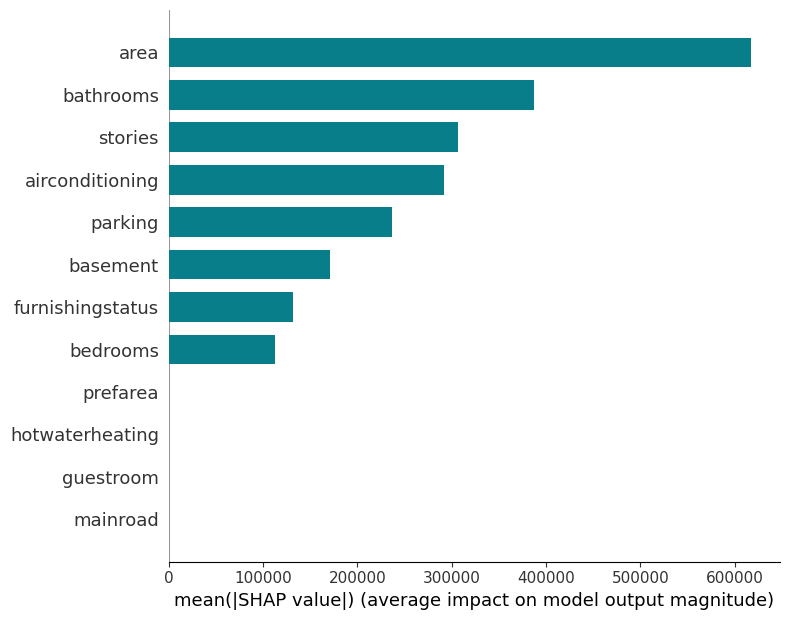

In [42]:
# shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_test, plot_type="bar", color='#087E8B')

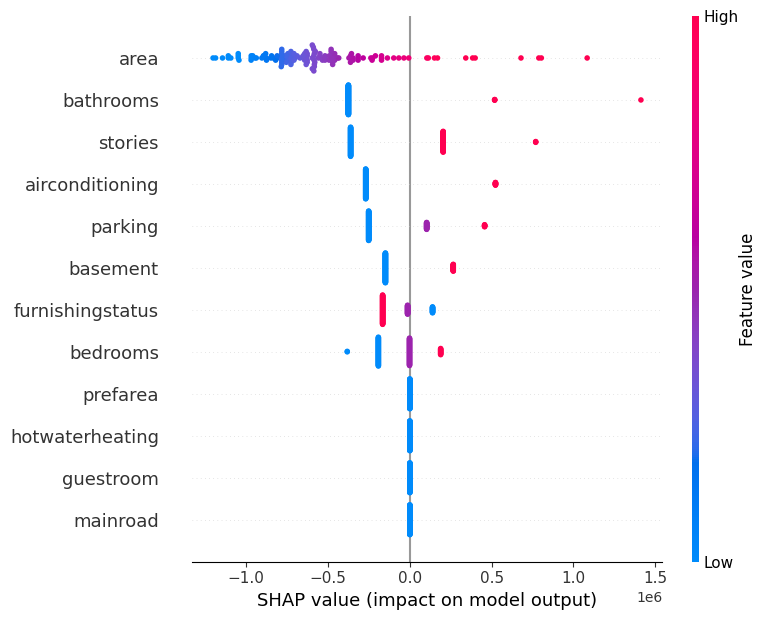

In [43]:
shap.summary_plot(shap_values, X_test)

For the AutoML according to SHAP Analysis the important features to determine the target variable are Area, Bathrooms and Basemet. Area and Bathrooms are the common feature which is important for Random Forest, Linear Regression Model and AutoML. Area has the highest value of feature importance and is placed first on the scale.

MIT License

Copyright (c) 2024 riyaneu

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

References
https://github.com/aiskunks/YouTube/blob/main/A_Crash_Course_in_Statistical_Learning/Model_Interpretability/smoke_detection_model_interpretibility.ipynb

https://www.kaggle.com/datasets/harishkumardatalab/housing-price-prediction

https://www.datacamp.com/tutorial/introduction-to-shap-values-machine-learning-interpretability